In [20]:
import pandas as pd
import numpy as np
import os
from shapely.geometry import Point, Polygon
import geopandas as gpd
from shapely.ops import nearest_points
import pyproj


cwd =os.getcwd()

### Structure socioeconomic data by year

In [21]:
socioeco_df = pd.read_excel(cwd+'/socioeconomic_data/socioeco_data.xlsx', sheet_name = 'Samlet')

postnr_columns =['POSTNR', 'YEAR', 'KOMKODE', 'SALGSPRIS']
kom_columns = ['KOMKODE', 'YEAR', 'DISINDK', 'KRIMINELITET', 'LAVINDK', 'SKILSMISSER', 'ANDEL_INDV']

post_df = socioeco_df[postnr_columns]
kom_df = socioeco_df[kom_columns]

years = [2011, 2015, 2019]
post_split = [post_df[post_df['YEAR'] == year] for year in years]
kom_split = [kom_df[kom_df['YEAR'] == year] for year in years]

### Merge school data and socioeconomic data by postal code and municipality

In [22]:
#school_data[school_data['beliggenhedskommunenr'] == 217]

In [23]:
df_list = []
for data, year in zip(post_split, [2011, 2015, 2019]):
    # load data
    soc_data = data
    school_data = pd.read_csv(cwd+f'/school_data/school_clean_{year-1}-{year}.csv', index_col=0)

    # merge data
    merged = pd.merge(left = school_data, right = soc_data, left_on = ['beliggenhedskommunenr', 'postnr'], right_on = ['KOMKODE', 'POSTNR'])

    # format
    merged.columns = merged.columns.str.lower()
    merged = merged.T.drop_duplicates().T

    merged.to_csv(f'postnr_background_vars{year}.csv')

    df_list.append(merged)

for data, year in zip(kom_split, [2011, 2015, 2019]):
    data.drop_duplicates()\
        .to_csv(f'kom_background_vars{year}.csv')

### Merge to closest school within same municipality (2019)

In [24]:
# Project geographical background variales from lat-lon to utm
df = pd.read_csv('postnr_background_vars2019.csv', index_col=0)
c = [Point(x, y) for x, y in zip(df['lon'], df['lat'])]
gdf = gpd.GeoDataFrame(df, geometry = c)

gdf.crs = {'init': 'epsg:4326'}
gdf_utm = gdf.to_crs(epsg = 32632)

# Narrow down to primary schools only
gdf_utm = gdf_utm[gdf_utm['institutionstype2'] == 'Grundskoler']

C:\Users\Gustav\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [25]:
# Load election data and find centroid for every district
valg_distrikt = gpd.read_file(cwd+'\scrape_geodata\geodata\dagi_10m_nohist_l1.afstemningsomraade\\afstemningsomraade.shp', driver = 'ESRI Shapefile')
valg_distrikt['centroid']=valg_distrikt['geometry'].centroid
valg_geo = valg_distrikt.set_geometry('centroid')

In [26]:
# Load municipality codes
kom_koder = list(pd.read_excel(cwd+'/school_data/data_download/kom_koder.xls', usecols = 'G:H', header = 3).iloc[:,0])
kom_koder.remove(411) # delete Christiansø

In [27]:
# Split into list of backgrounddata and election data by municipality code
kommune_split = [[gdf_utm[gdf_utm['beliggenhedskommunenr'] == kom_kode], valg_geo[valg_geo['kommunekod'].astype(int) == kom_kode]] for kom_kode in kom_koder]

# For each municipality, find closest school to each polling place.
def near(point, pts):
    """
    Finds closest among pts to point and saves the relevant institutionsnr
    """
    nearest = gdf_utm.geometry == nearest_points(point, pts)[1]
    return gdf_utm[nearest]['institutionsnummer'].values[0]

for gdf, valg_geo in kommune_split:
    pts = gdf.geometry.unary_union
    valg_geo['institutionsnummer'] = valg_geo.apply(lambda row: near(row.geometry, pts), axis = 1)

# concat school data
gdf_utm = pd.concat([kommune_split[i][0] for i in range(len(kommune_split))])

# concat election data
valg_geo = pd.concat([kommune_split[i][1] for i in range(len(kommune_split))])

# merge election to school in 'intitutionsnummer
merge1 = pd.merge(left=valg_geo, right = gdf_utm, on = 'institutionsnummer')

In [28]:
# merge merge1 to mapping on 'objectid'
mapping = pd.read_excel(cwd+'/scrape_geodata/mapping2019.xlsx')
mapping.objectid = mapping.objectid.astype(str)
merge2 = pd.merge(left = merge1, right = mapping[['objectid', 'refs']], on = 'objectid')

In [29]:
# merge to election results
election_result = pd.read_csv(cwd+'/scrape_geodata/data2019.csv')

merge3 = pd.merge(left = merge2, right = election_result, on = 'refs')
merge3.kommunekod = merge3.kommunekod.astype(int).astype(str)

In [30]:
# merge to background vars on kommune level
background = pd.read_csv('kom_background_vars2019.csv', index_col = 0)

background.KOMKODE = background.KOMKODE.astype(str)
background

all_2019 = pd.merge(left = merge3, right = background, left_on = 'kommunekod', right_on = 'KOMKODE')

# Not necessary, and the file is very big, but can be used as checkpoint
# all_2019.to_csv('all_2019.csv')


In [31]:
all_2019.columns = all_2019.columns.str.lower()
col_vars = ['objectid','navn_x', 'afstemni00','kommunekod', 'institutionsnummer', 'karakter', 'soc_ref', 'postnr', 'navn_y', 'institutionstype2', 'institutionstype3', 'year_x', 'salgspris', 'party', 'votes', 'eligible_count', 'blank', 'invalid', 'total_valid', 'total_casted', 'time_stamp', 'names', 'constituency', 'voting_area', 'municipality', 'disindk', 'kriminelitet', 'lavindk', 'skilsmisser', 'andel_indv', 'geometry_x']

temp_2019 = all_2019[col_vars]

### Create variables for voting counts

In [32]:
left_parties = ['Socialdemokratiet', 'Radikale Venstre', 'SF - Socialistisk Folkeparti', 'Enhedslisten - De Rød-Grønne', 'Alternativet']
right_parties = ['Det Konservative Folkeparti', 'Nye Borgerlige', 'Klaus Riskær Pedersen', 'Liberal Alliance', 'Kristendemokraterne', 'Dansk Folkeparti', 'Stram Kurs', 'Venstre, Danmarks Liberale Parti']

left_dummy = [int(party in left_parties) for party in temp_2019['party']]
right_dummy = [int(party in right_parties) for party in temp_2019['party']]
independent_dummy = [int(party not in left_parties+right_parties) for party in temp_2019['party']]

temp_2019['left_dummy'], temp_2019['right_dummy'], temp_2019['independent_dummy'] = left_dummy, right_dummy, independent_dummy

temp_2019['left_votes'], temp_2019['right_votes'], temp_2019['independent_votes'] = left_dummy*temp_2019['votes'], right_dummy*temp_2019['votes'], independent_dummy*temp_2019['votes']

votes_df = temp_2019[['objectid', 'votes', 'left_votes', 'right_votes', 'independent_votes']].groupby(by = 'objectid').sum()

pre_merge = temp_2019.drop(['votes','left_votes', 'right_votes', 'independent_votes', 'left_dummy', 'right_dummy', 'independent_dummy', 'party'], axis = 1)
finalish_df = pd.merge(left = pre_merge, right = votes_df, on = 'objectid')\
            .drop_duplicates(subset = 'objectid')\
            .reset_index(drop = True)

finalish_df['left_share'] = finalish_df['left_votes']/finalish_df['total_valid']
finalish_df['right_share'] = finalish_df['right_votes']/finalish_df['total_valid']
finalish_df['independent_share'] = finalish_df['independent_votes']/finalish_df['total_valid']

C:\Users\Gustav\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Gustav\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [33]:
final_gdf = gpd.GeoDataFrame(finalish_df[['objectid', 'afstemni00','navn_x', 'kommunekod', 'municipality', 'constituency','postnr', 'time_stamp', 'votes', 'eligible_count', 'total_casted', 'total_valid', 'left_votes', 'right_votes', 'independent_votes', 'blank', 'invalid', 'left_share', 'right_share', 'independent_share', 'institutionsnummer', 'navn_y', 'institutionstype2', 'institutionstype3', 'karakter', 'soc_ref', 'salgspris', 'disindk', 'kriminelitet', 'lavindk','skilsmisser', 'andel_indv', 'geometry_x']])

final_gdf = final_gdf.rename(columns = {'navn_x': 'afstem_navn2', 'afstemni00': 'afstem_navn1', 'soc_ref': 'karakter_soc_ref', 'navn_y': 'skole_navn', 'blank': 'blank_votes', 'invalid': 'invalid_votes', 'votes': 'votes', 'municipality': 'kommunenavn', 'constituency': 'opst_kreds', 'geometry_x':'geometry'})

final_gdf['area'] = final_gdf.geometry.area
final_gdf['pop_density'] = final_gdf['eligible_count']/final_gdf['area']

final_gdf.to_csv('final_data2019.csv', encoding = 'utf-8-sig')

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

pipe_preproc = make_pipeline(PolynomialFeatures(), 
                             StandardScaler())

print(pipe_preproc.steps[0])
print(pipe_preproc.steps[1])

('polynomialfeatures', PolynomialFeatures())
('standardscaler', StandardScaler())


In [35]:
final_gdf['left_share_norm']=final_gdf['left_share']/(final_gdf['left_share']+final_gdf['right_share'])
final_gdf['left_share_norm']

0       0.679018
1       0.682424
2       0.654014
3       0.687382
4       0.755921
          ...   
1378    0.549085
1379    0.493011
1380    0.612910
1381    0.613554
1382    0.508466
Name: left_share_norm, Length: 1383, dtype: float64

In [36]:
final_gdf.columns

Index(['objectid', 'afstem_navn1', 'afstem_navn2', 'kommunekod', 'kommunenavn',
       'opst_kreds', 'postnr', 'time_stamp', 'votes', 'eligible_count',
       'total_casted', 'total_valid', 'left_votes', 'right_votes',
       'independent_votes', 'blank_votes', 'invalid_votes', 'left_share',
       'right_share', 'independent_share', 'institutionsnummer', 'skole_navn',
       'institutionstype2', 'institutionstype3', 'karakter',
       'karakter_soc_ref', 'salgspris', 'disindk', 'kriminelitet', 'lavindk',
       'skilsmisser', 'andel_indv', 'geometry', 'area', 'pop_density',
       'left_share_norm'],
      dtype='object')

In [51]:
len(final_gdf['left_share_norm'].values)

1383

In [245]:
X = final_gdf[['karakter', 'karakter_soc_ref', 'salgspris', 'disindk', 'kriminelitet', 'lavindk',
       'skilsmisser', 'andel_indv', 'pop_density']]
y = final_gdf['left_share_norm']

In [294]:
# splitting into development (2/3) and test data (1/3)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=1)

# splitting development into train (1/3) and validation (1/3)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=1)

In [249]:
from sklearn.linear_model import Lasso, Ridge, LinearRegression
pipe_lr = make_pipeline(PolynomialFeatures(interaction_only=True, degree=2, include_bias=True), 
                        StandardScaler(),
                        LinearRegression())

pipe_lr.fit(X_dev, y_dev)

Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(interaction_only=True)),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [250]:
((pipe_lr.predict(X_test)- y_test)**2).mean()

0.004901480683898845

## Lasso:

In [254]:
from sklearn.metrics import mean_squared_error as mse

perform = []
lambdas = np.logspace(-4, 4, 33)
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(include_bias=True), 
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=1))
    pipe_lasso.fit(X_train, y_train)
    y_pred = pipe_lasso.predict(X_val)
    perform.append(mse(y_pred, y_val))
    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])



C:\Users\Gustav\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0939716447262009, tolerance: 0.0005527937217527237
  positive)
C:\Users\Gustav\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07807740010019981, tolerance: 0.0005527937217527237
  positive)
C:\Users\Gustav\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.060583777519856774, tolerance: 0.0005527937217527237
  positive)


Optimal lambda: 0.0001
Validation MSE: 0.005


## Ridge:

In [255]:
from sklearn.metrics import mean_squared_error as mse

perform = []
lambdas = np.logspace(-4, 4, 33)
for lambda_ in lambdas:
    pipe_ridge = make_pipeline(PolynomialFeatures(include_bias=True), 
                               StandardScaler(),
                               Ridge(alpha=lambda_, random_state=1))
    pipe_ridge.fit(X_train, y_train)
    y_pred = pipe_ridge.predict(X_val)
    perform.append(mse(y_pred, y_val))
    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])



Optimal lambda: 1.0
Validation MSE: 0.005


<AxesSubplot:>

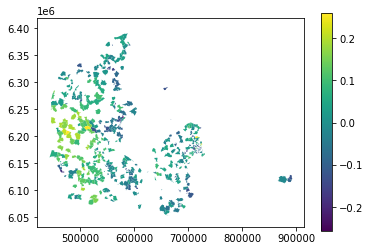

In [288]:
errors = pipe_ridge.predict(X_test)-y_test
error_gdf = final_gdf.merge(pd.DataFrame(errors), left_index=True, right_index=True, how='left')
error_gdf.plot(column='left_share_norm_y', legend=True)

<AxesSubplot:xlabel='x_axis', ylabel='0'>

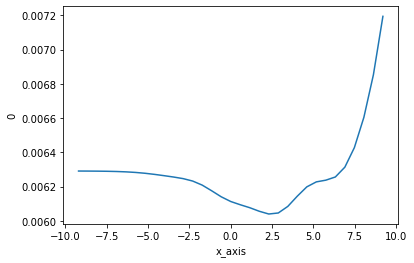

In [237]:
plot_df = pd.DataFrame(hyperparam_perform).reset_index()
plot_df['index'] = np.log(plot_df['index'])
plot_df['x_axis'] = plot_df['index']
import seaborn as sns
sns.lineplot(data=plot_df, x='x_axis', y=0)

In [307]:
from sklearn.model_selection import KFold, LeaveOneOut
kfolds = KFold(n_splits=10)
folds = list(kfolds.split(X_dev, y_dev))
# outer loop: lambdas
mseCV = []
lambdas = np.logspace(-4, 4, 33)
for lambda_ in lambdas:    
    # inner loop: folds
    mseCV_ = []    
    for train_idx, val_idx in folds:        
        # train model and compute MSE on test fold
        pipe_ridgeCV = make_pipeline(PolynomialFeatures(degree=2, include_bias=True),
                                     StandardScaler(),
                                     Ridge(alpha=lambda_, random_state=1))            
        X_train, y_train = X_dev.values[train_idx], y_dev.values[train_idx]
        X_val, y_val = X_dev.values[val_idx], y_dev.values[val_idx] 
        pipe_ridgeCV.fit(X_train, y_train)        
        mseCV_.append(mse(pipe_ridgeCV.predict(X_val), y_val))    
        
    # store result    
    mseCV.append(mseCV_) 
    
# convert to DataFrame
lambdaCV = pd.DataFrame(mseCV, index=lambdas)

<AxesSubplot:>

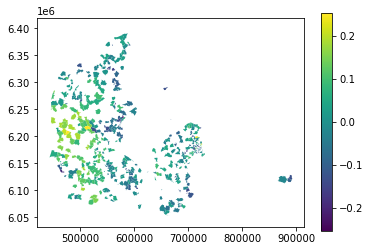

In [308]:
errors = pipe_ridgeCV.predict(X_test)-y_test
error_gdf = final_gdf.merge(pd.DataFrame(errors), left_index=True, right_index=True, how='left')
error_gdf.plot(column='left_share_norm_y', legend=True)

<AxesSubplot:xlabel='x_axis', ylabel='0'>

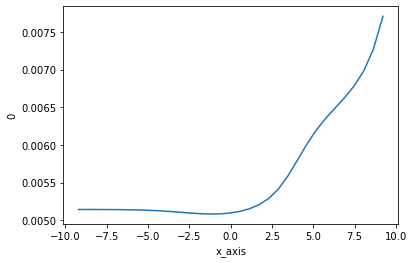

In [242]:
plot_df = pd.DataFrame(lambdaCV.mean(axis=1)).reset_index()
plot_df['index'] = np.log(plot_df['index'])
plot_df['x_axis'] = plot_df['index']
import seaborn as sns
sns.lineplot(data=plot_df, x='x_axis', y=0)

In [243]:
lambdaCV.mean(axis=1)
errors = pipe_ridge.predict(X_test)-y_test
error_gdf = final_gdf.merge(pd.DataFrame(errors), left_index=True, right_index=True, how='left')
error_gdf.plot(column='left_share_norm_y', legend=True)

0.000100        0.005145
0.000178        0.005145
0.000316        0.005144
0.000562        0.005144
0.001000        0.005143
0.001778        0.005142
0.003162        0.005140
0.005623        0.005136
0.010000        0.005131
0.017783        0.005124
0.031623        0.005115
0.056234        0.005105
0.100000        0.005095
0.177828        0.005088
0.316228        0.005085
0.562341        0.005088
1.000000        0.005099
1.778279        0.005120
3.162278        0.005156
5.623413        0.005210
10.000000       0.005291
17.782794       0.005414
31.622777       0.005587
56.234133       0.005797
100.000000      0.006010
177.827941      0.006199
316.227766      0.006356
562.341325      0.006494
1000.000000     0.006632
1778.279410     0.006788
3162.277660     0.006987
5623.413252     0.007272
10000.000000    0.007707
dtype: float64

In [309]:
from sklearn.model_selection import KFold, LeaveOneOut
kfolds = LeaveOneOut()
folds = list(kfolds.split(X_dev, y_dev))
# outer loop: lambdas
mseCV = []
lambdas = np.logspace(-4, 4, 33)
for lambda_ in lambdas:    
    # inner loop: folds
    mseCV_ = []    
    for train_idx, val_idx in folds:        
        # train model and compute MSE on test fold
        pipe_ridgeCV = make_pipeline(PolynomialFeatures(degree=2, include_bias=True),
                                     StandardScaler(),
                                     Ridge(alpha=lambda_, random_state=1))            
        X_train, y_train = X_dev.values[train_idx], y_dev.values[train_idx]
        X_val, y_val = X_dev.values[val_idx], y_dev.values[val_idx] 
        pipe_ridgeCV.fit(X_train, y_train)        
        mseCV_.append(mse(pipe_ridgeCV.predict(X_val), y_val))    
        
    # store result    
    mseCV.append(mseCV_) 
    
# convert to DataFrame
lambdaCV = pd.DataFrame(mseCV, index=lambdas)

In [320]:
error_gdf[['kommunenavn', 'opst_kreds','left_share_norm_x', 'left_share_norm_y']].sort_values(by='left_share_norm_x', ascending=False).dropna()

,kommunenavn,opst_kreds,left_share_norm_x,left_share_norm_y
51,København Kommune,Brønshøjkredsen,0.835885,-0.242268
6,København Kommune,Nørrebrokredsen,0.834906,-0.175485
48,København Kommune,Nørrebrokredsen,0.806708,-0.140194
19,København Kommune,Nørrebrokredsen,0.795474,-0.084410
47,København Kommune,Vesterbrokredsen,0.779431,-0.116090
...,...,...,...,...
1142,Ringkøbing-Skjern Kommune,Ringkøbingkredsen,0.253937,0.184741
1130,Ringkøbing-Skjern Kommune,Ringkøbingkredsen,0.239678,0.204331
239,Hørsholm Kommune,Fredensborgkredsen,0.235714,0.235337
1115,Ikast-Brande Kommune,Ikastkredsen,0.213752,0.247523


In [353]:
error_gdf['correct_prediction'] = ""
error_gdf['correct_prediction'][(error_gdf['left_share_norm_x']>0.5) & ((error_gdf['left_share_norm_y']+error_gdf['left_share_norm_x'])>0.5)] = 1
error_gdf['correct_prediction'][(error_gdf['left_share_norm_x']<0.5) & ((error_gdf['left_share_norm_y']+error_gdf['left_share_norm_x'])<0.5)] = 1

error_gdf['actual prediction'] = ""
error_gdf['correct_prediction'][(error_gdf['left_share_norm_x']>0.5) & ((error_gdf['left_share_norm_y']+error_gdf['left_share_norm_x'])>0.5)] = 1
error_gdf['correct_prediction'][(error_gdf['left_share_norm_x']<0.5) & ((error_gdf['left_share_norm_y']+error_gdf['left_share_norm_x'])<0.5)] = 1

C:\Users\Gustav\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Gustav\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:>

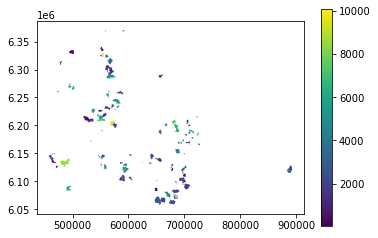

In [342]:
error_gdf[error_gdf['correct_prediction']==1].dropna().plot(column='eligible_count', legend=True)

In [352]:
# len(error_gdf[(error_gdf['correct_prediction']==1)&(error_gdf['eligible_count']<2000)])/error_gdf.correct_prediction.sum()
len(error_gdf[(error_gdf['correct_prediction']==0)&(error_gdf['eligible_count']<2000)].dropna())/(len(error_gdf.dropna())-error_gdf.correct_prediction.sum())

0.30303030303030304

In [348]:
(len(error_gdf.dropna())-error_gdf.correct_prediction.sum())

99

In [340]:
error_gdf.correct_prediction.sum()/len(error_gdf.dropna())


0.7780269058295964

<AxesSubplot:>

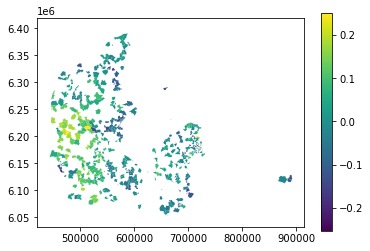

In [310]:
errors = pipe_ridgeCV.predict(X_test)-y_test
error_gdf = final_gdf.merge(pd.DataFrame(errors), left_index=True, right_index=True, how='left')
error_gdf.plot(column='left_share_norm_y', legend=True)

<AxesSubplot:xlabel='x_axis', ylabel='0'>

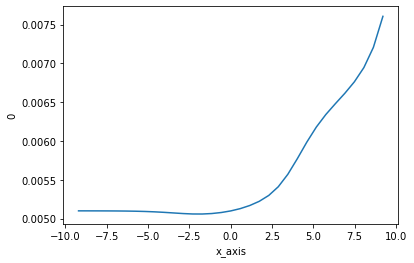

In [230]:
plot_df = pd.DataFrame(lambdaCV.mean(axis=1)).reset_index()
plot_df['index'] = np.log(plot_df['index'])
plot_df['x_axis'] = plot_df['index']
import seaborn as sns
sns.lineplot(data=plot_df, x='x_axis', y=0)